Key features in v8:

1. Long Short

Reference
Binance Margin Bracket
https://www.binance.com/en/futures/trading-rules/quarterly/leverage-margin

## Import Library

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import ta

from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

2024-09-02 14:19:17.230935: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Defining Functions

### Feature Engineering

In [3]:
def addSMA(data, sma_start: int, sma_end: int, sma_step: int):
    sma_range = range(sma_start, sma_end, sma_step)

    for window in sma_range:
        # SMA/Close
        # relative value of SMA to closing price
        data.loc[:,f"SMA_{window}"] = ta.trend.SMAIndicator(data.Close, window=window).sma_indicator() / data.Close

    for i in range(len(sma_range)):
        for j in range(i+1, len(sma_range)):
            # (SMA_1 - SMA_2) / Close
            data.loc[:,f"SMA_DELTA_{sma_range[i]}_{sma_range[j]}"] = data.loc[:,f"SMA_{sma_range[i]}"] - data.loc[:,f"SMA_{sma_range[j]}"]

    return data

In [4]:
def addEMA(data, ema_start: int, ema_end: int, ema_step: int):
    ema_range = range(ema_start, ema_end, ema_step)

    for window in ema_range:
        # EMA/Close
        # relative value of EMA to closing price
        data.loc[:,f"EMA_{window}"] = ta.trend.EMAIndicator(data.Close, window=window).ema_indicator() / data.Close

    for i in range(len(ema_range)):
        for j in range(i+1, len(ema_range)):
            # (EMA_1 - EMA_2) / Close
            data.loc[:,f"EMA_DELTA_{ema_range[i]}_{ema_range[j]}"] = data.loc[:,f"EMA_{ema_range[i]}"] - data.loc[:,f"EMA_{ema_range[j]}"]

    return data

In [5]:
def feature_generation(
    data,
    sma_start: int = 20,
    sma_end  : int = 100,
    sma_step : int = 20,
    ema_start: int = 20,
    ema_end  : int = 100,
    ema_step : int = 20
    ):
    """
    Input
    --------
    X: pd.DataFrame


    Output
    --------
    X: pd.DataFrame
    """
    close = data.Close

    # SMA
    data = addSMA(data=data, sma_start=sma_start, sma_end=sma_end, sma_step=sma_step)

    # EMA
    data = addEMA(data=data, ema_start=ema_start, ema_end=ema_end, ema_step=ema_step)

    # RSI
    data["RSI"] = ta.momentum.RSIIndicator(data.Close).rsi()
  
    # MACD
    data["MACD"] = ta.trend.MACD(data.Close).macd()

    # ATR
    data["ATR"] = ta.volatility.AverageTrueRange(data.High, data.Low, data.Close).average_true_range()

    # BollingerBands
    upper = ta.volatility.BollingerBands(data.Close).bollinger_hband()
    lower = ta.volatility.BollingerBands(data.Close).bollinger_lband()

    data["BB_upper"] = (upper - close) / close
    data["BB_lower"] = (lower - close) / close
    data["BB_width"] = (upper - lower) / close

    # Garman Klass Volatility
    data["garman_klass_vol"] = ((np.log(data.High)-np.log(data.Low))**2)/2-(2*np.log(2)-1)*((np.log(data.Close)-np.log(data.Open))**2)

    return data

In [6]:
def preprocess(data,
               PCA_components = 8):
  # Feature generation
  data_features = feature_generation(data)

  # Feature
  remove_columns = ["Open",
                    "High",
                    "Low",
                    "Close"]
  features = data_features.drop(remove_columns, axis=1).dropna()

  # normalize
  scaler = StandardScaler()
  features = pd.DataFrame(
    scaler.fit_transform(features),
    index=features.index,
    columns=features.columns)

  # PCA
  pca = PCA(n_components=PCA_components)
  features = pd.DataFrame(
    pca.fit_transform(features),
    index=features.index)
  
  return features

In [7]:
def create_LSTM_input(data, time_steps=10):
    num_samples = data.shape[0] - time_steps + 1
    X = np.array([data[i:i+time_steps] for i in range(num_samples)])
    return X


## Defining Model

In [8]:
class LSTM_stack(layers.Layer):
    """stacks of LSTM with dropout, followed by dense layer"""

    def __init__(
        self,
        dropout_rate: float = 0.2
        ):
        super().__init__()

        self.lstm_1 = layers.LSTM(
            units=50,
            return_sequences=True,
            )

        self.lstm_2 = layers.LSTM(
            units=50,
            return_sequences=True,
            )

        self.lstm_3 = layers.LSTM(
            units=50,
            return_sequences=False,
            )

        self.dense_1 = layers.Dense(
            units=1
            )

        self.dropout_1 = layers.Dropout(dropout_rate)

    def call(self, inputs):
        x = self.lstm_1(inputs)
        x = self.dropout_1(x)
        x = self.lstm_2(inputs)
        x = self.dropout_1(x)
        x = self.lstm_3(inputs)
        x = self.dropout_1(x)
        return self.dense_1(x)

## Defining Trading Environment

In [9]:
class Coin:
    def __init__(self, symbol, ohlcv):
        self.symbol = symbol
        self.ohlcv = ohlcv
        self.logret = self.calculate_logret()
        self.trading_history = []  # List to store trading history
        self.volatility = self.calculate_volatility()
        self.features = preprocess(
            pd.concat([
                self.ohlcv,
                self.logret,
                self.volatility],
                axis=1))
        self.y = self.logret.shift(-1)

    def calculate_logret(self):
        return pd.DataFrame(
            np.log((self.ohlcv.Close / self.ohlcv.Close.shift(1)))).rename(columns={"Close": "logret"})

    def calculate_volatility(self):
        return pd.DataFrame(
            self.logret.rolling(window=14).std()).rename(columns={"logret": "vol"})

In [10]:
class Market:
    def __init__(
        self,
        cash = 10000):
        self.coins = {}  # Dictionary to store coins
        self.init_cash = cash
        self.cash = self.init_cash  # Initial cash balance
        self.assets = {}  # Dictionary to store quantity of each asset
        self.prices = pd.DataFrame()

        self.margin_rate = 0.004


    def add_coin(self, coin):
        self.coins[coin.symbol] = coin
        self.assets[coin.symbol] = 0  # Initialize asset quantity to 0

        close = pd.DataFrame(coin.ohlcv.Close).rename(columns={"Close": coin.symbol})
        self.prices = pd.concat([self.prices, close], axis=1)
        
        self.coins[coin.symbol].trading_history = []
        self.coins[coin.symbol].position = "Closed"

        self.coins[coin.symbol].entry_cost = 0

    def reset(self):
        self.cash = self.init_cash
        for symbol in self.coins:
            self.coins[symbol].trading_history = []
            self.assets[symbol] = 0  # Initialize asset quantity to 0
            self.coins[symbol].position = "Closed"
            self.coins[symbol].entry_cost = 0

    def trade(self, symbol, action, quantity, price, time):
        if action == "long":
            self.market_long(symbol, quantity, price, time)

        if action == "short":
            self.market_short(symbol, quantity, price, time)

        elif action == "close":
            if self.coins[symbol].position != "Closed":
                if self.coins[symbol].position == "Long":
                    self.market_long_close(symbol, quantity, price, time)
                if self.coins[symbol].position == "Short":
                    self.market_short_close(symbol, quantity, price, time)

    def market_long(self, symbol, quantity, price, time):        
        available_margin = self.cash
        maintenance_margin = quantity * price * self.margin_rate
        margin_balance = available_margin
        margin_ratio = maintenance_margin / margin_balance

        if margin_ratio < 1:
            self.assets[symbol] += quantity
            self.coins[symbol].trading_history.append(
                {
                    "action": "long",
                    "quantity": quantity,
                    "price": price,
                    "time": time
                })
            self.coins[symbol].entry_cost = quantity * price
            self.coins[symbol].position = "Long"

    def market_long_close(self, symbol, quantity, price, time):
        notional_value = quantity * price

        self.cash += notional_value - self.coins[symbol].entry_cost

        self.assets[symbol] -= quantity
        self.coins[symbol].trading_history.append(
            {
                "action": "close",
                "quantity": quantity,
                "price": price,
                "time": time
            })
        self.coins[symbol].entry_cost = 0
        self.coins[symbol].position = "Closed"

    def market_short(self, symbol, quantity, price, time):
        self.assets[symbol] += quantity
        self.coins[symbol].trading_history.append(
            {
                "action": "short",
                "quantity": quantity,
                "price": price,
                "time": time
            })
        self.coins[symbol].entry_cost = quantity * price
        self.coins[symbol].position = "Short"

    def market_short_close(self, symbol, quantity, price, time):
        notional_value = quantity * price

        self.cash += notional_value - self.coins[symbol].entry_cost

        self.assets[symbol] -= quantity
        self.coins[symbol].trading_history.append(
            {
                "action": "close",
                "quantity": quantity,
                "price": price,
                "time": time
            })
        self.coins[symbol].entry_cost = 0
        self.coins[symbol].position = "Closed"

    def get_margin_ratio(self, time):
        maintenance_margin = 0
        margin_balance = self.cash
        for symbol in self.coins:
            qty = self.assets[symbol]
            price = self.prices.loc[time, symbol]
            entry_cost = self.coins[symbol].entry_cost

            notional_value = qty * price

            maintenance_margin += notional_value * self.margin_rate
            margin_balance += notional_value - entry_cost
        
        margin_ratio = maintenance_margin / margin_balance

        return margin_ratio


## Parameters

This section contains all the parameters.

In [11]:
symbols = [
    "ADAUSDT",
    "BNBUSDT",
    "BTCUSDT",
    "EOSUSDT",
    "ETHUSDT",
    "LTCUSDT",
    "NEOUSDT",
    "QTUMUSDT",
    "XRPUSDT"
    ]

interval = "15m"

## Training the Model

This section outputs training and testing data for the use of the following sections.

### Creating the market for training the model

In [12]:
model = keras.models.load_model("LSTM_full.keras")

## Testing the model

In [14]:
market_test = Market()
for symbol in symbols:
    data_test = pd.read_csv(f"Binance Data/Testing/{interval}/{symbol}.csv", index_col="index")
    data_test = data_test.set_index(pd.DatetimeIndex(pd.to_datetime(data_test.index)))
    coin = Coin(symbol, data_test)
    market_test.add_coin(coin)

In [15]:
predictions = {}

for symbol in symbols:
    X_test = create_LSTM_input(market_test.coins[symbol].features)
    predictions[symbol] = model.predict(X_test)


1090/1090 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


### Long Only

In [17]:
long_threshold = 0.5
close_long_threshold = 0

short_threshold = -0.5
close_short_threshold = 0

leverage = 2

results = {}

for symbol in symbols:
    market_test.reset()
    test_time = market_test.coins[symbol].features[-len(X_test):].index
    account_values = np.zeros((len(test_time)))
    for index, time in enumerate(test_time):
        price = market_test.prices.loc[time, symbol]

        if market_test.coins[symbol].position == "Closed" and prediction[index] > long_threshold:
            qty = market_test.cash * leverage / price
            market_test.trade(
                symbol=symbol,
                action="long",
                quantity=qty,
                price=price,
                time=time
            )

        if market_test.coins[symbol].position == "Long" and prediction[index] < close_long_threshold:
            qty = market_test.assets[symbol]
            market_test.trade(
                symbol=symbol,
                action="close",
                quantity=qty,
                price=price,
                time=time
            )

        if market_test.get_margin_ratio(time) >= 1:
            print(f"{symbol} liquidated")
            continue

        account_values[index] = market_test.cash + \
            market_test.assets[symbol] * market_test.prices.loc[time, symbol] - \
                market_test.coins[symbol].entry_cost

    if market_test.coins[symbol].position != "Closed":
        price = market_test.prices.loc[time, symbol]
        qty = market_test.assets[symbol]
        market_test.trade(symbol, "close", qty, price, time)

    account_values[index] = market_test.cash + \
        market_test.assets[symbol] * market_test.prices.loc[time, symbol] - \
            market_test.coins[symbol].entry_cost

    results[symbol] = account_values

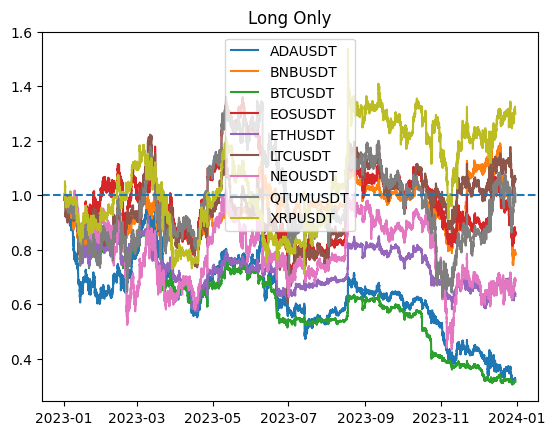

In [18]:
for symbol in symbols:
    buy_and_hold = market_test.prices.loc[test_time,symbol] / market_test.prices.loc[test_time[0],symbol]
    strategy_pl = results[symbol] / results[symbol][0]
    score = strategy_pl / buy_and_hold

    plt.plot(
        test_time,
        score,
        label = symbol
    )

plt.axhline(y=1, linestyle='--')

plt.title("Long Only")
plt.legend()
plt.show()

### Short Only

In [19]:
long_threshold = 0.5
close_long_threshold = 0

short_threshold = -0.5
close_short_threshold = 0

leverage = 2

results = {}

for symbol in symbols:
    market_test.reset()
    test_time = market_test.coins[symbol].features[-len(X_test):].index

    account_values = np.zeros((len(test_time)))
    for index, time in enumerate(test_time):
        price = market_test.prices.loc[time, symbol]

        if market_test.coins[symbol].position == "Closed" and prediction[index] < short_threshold:
            qty = - market_test.cash * leverage / price
            market_test.trade(
                symbol=symbol,
                action="short",
                quantity=qty,
                price=price,
                time=time
            )

        if market_test.coins[symbol].position == "Short" and prediction[index] > close_short_threshold:
            qty = market_test.assets[symbol]
            market_test.trade(
                symbol=symbol,
                action="close",
                quantity=qty,
                price=price,
                time=time
            )

        if market_test.get_margin_ratio(time) >= 1:
            print(f"{symbol} liquidated")
            continue

        account_values[index] = market_test.cash + \
            market_test.assets[symbol] * market_test.prices.loc[time, symbol] - \
                market_test.coins[symbol].entry_cost

    if market_test.coins[symbol].position != "Closed":
        price = market_test.prices.loc[time, symbol]
        qty = market_test.assets[symbol]
        market_test.trade(symbol, "close", qty, price, time)

    account_values[index] = market_test.cash + \
        market_test.assets[symbol] * market_test.prices.loc[time, symbol] - \
            market_test.coins[symbol].entry_cost

    results[symbol] = account_values

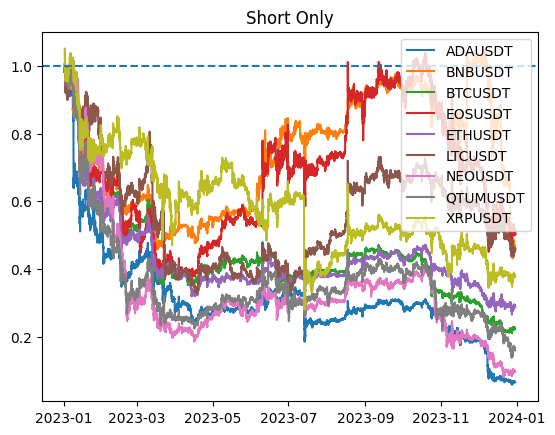

In [20]:
for symbol in symbols:
    buy_and_hold = market_test.prices.loc[test_time,symbol] / market_test.prices.loc[test_time[0],symbol]
    strategy_pl = results[symbol] / results[symbol][0]
    score = strategy_pl / buy_and_hold

    plt.plot(
        test_time,
        score,
        label = symbol
    )

plt.axhline(y=1, linestyle='--')

plt.title("Short Only")
plt.legend()
plt.show()

### Long Short

In [21]:
long_threshold = 0.5
close_long_threshold = 0

short_threshold = -0.5
close_short_threshold = 0

leverage = 2

results = {}

for symbol in symbols:
    market_test.reset()

    test_time = market_test.coins[symbol].features[-len(X_test):].index

    account_values = np.zeros((len(test_time)))
    for index, time in enumerate(test_time):
        price = market_test.prices.loc[time, symbol]

        if market_test.coins[symbol].position == "Closed" and prediction[index] > long_threshold:
            qty = market_test.cash * leverage / price
            market_test.trade(
                symbol=symbol,
                action="long",
                quantity=qty,
                price=price,
                time=time
            )

        if market_test.coins[symbol].position == "Long" and prediction[index] < close_long_threshold:
            qty = market_test.assets[symbol]
            market_test.trade(
                symbol=symbol,
                action="close",
                quantity=qty,
                price=price,
                time=time
            )

        if market_test.coins[symbol].position == "Closed" and prediction[index] < short_threshold:
            qty = - market_test.cash * leverage / price
            market_test.trade(
                symbol=symbol,
                action="short",
                quantity=qty,
                price=price,
                time=time
            )

        if market_test.coins[symbol].position == "Short" and prediction[index] > close_short_threshold:
            qty = market_test.assets[symbol]
            market_test.trade(
                symbol=symbol,
                action="close",
                quantity=qty,
                price=price,
                time=time
            )

        if market_test.get_margin_ratio(time) >= 1:
            print(f"{symbol} liquidated")
            continue

        account_values[index] = market_test.cash + \
            market_test.assets[symbol] * market_test.prices.loc[time, symbol] - \
                market_test.coins[symbol].entry_cost

    if market_test.coins[symbol].position != "Closed":
        price = market_test.prices.loc[time, symbol]
        qty = market_test.assets[symbol]
        market_test.trade(symbol, "close", qty, price, time)

    account_values[index] = market_test.cash + \
        market_test.assets[symbol] * market_test.prices.loc[time, symbol] - \
            market_test.coins[symbol].entry_cost

    results[symbol] = account_values

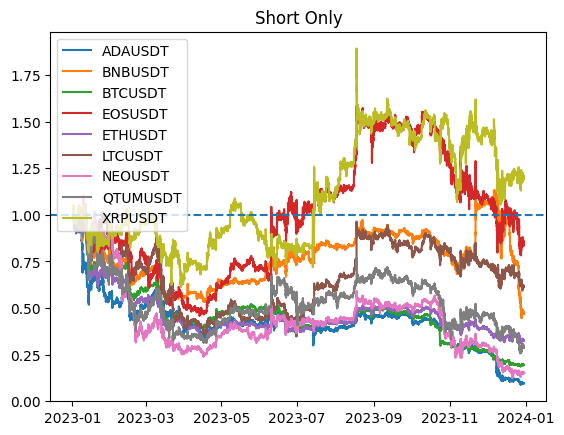

In [22]:
for symbol in symbols:
    buy_and_hold = market_test.prices.loc[test_time,symbol] / market_test.prices.loc[test_time[0],symbol]
    strategy_pl = results[symbol] / results[symbol][0]
    score = strategy_pl / buy_and_hold

    plt.plot(
        test_time,
        score,
        label = symbol
    )

plt.axhline(y=1, linestyle='--')

plt.title("Long Short")
plt.legend()
plt.show()

# To Do
- test with simple strategy
    - only one asset in a portfolio
    - test which asset performs the best
    - check G/L distribution at different time
    - see if can mitigate loss by creating a portfolio
- Model volatility and trade option
- Apply the same PCA and MinMaxScaler to train, val and test

## Backtesting

## Results

## Ad hoc